In [48]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("24120901_sf_fire_calls_App").getOrCreate()

In [49]:
df = spark.read.format('csv').load('data/sf-fire-calls.csv')

In [50]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [51]:
from pyspark.sql.types import *

fire_schema = StructType([
    StructField('CallNumber', IntegerType(), True),
    StructField('UnitID', StringType(), True),
    StructField('IncidentNumber', IntegerType(), True),
    StructField('CallType', StringType(), True),
    StructField('CallDate', StringType(), True),
    StructField('WatchDate', StringType(), True),
    StructField('CallFinalDisposition', StringType(), True),
    StructField('AvailableDtTm', StringType(), True),
    StructField('Address', StringType(), True),
    StructField('City', StringType(), True),
    StructField('Zipcode', StringType(), True),
    StructField('Battalion', StringType(), True),
    StructField('StationArea', StringType(), True),
    StructField('Box', StringType(), True),
    StructField('OriginalPriority', IntegerType(), True),
    StructField('Priority', IntegerType(), True),
    StructField('FinalPriority', IntegerType(), True),
    StructField('ALSUnit', StringType(), True),
    StructField('CallTypeGroup', StringType(), True),
    StructField('NumAlarms', IntegerType(), True),
    StructField('UnitType', StringType(), True),
    StructField('UnitSequenceInCallDispatch', IntegerType(), True),
    StructField('FirePreventionDistrict', StringType(), True),
    StructField('SupervisorDistrict', StringType(), True),
    StructField('Neighborhood', StringType(), True),
    StructField('Location', StringType(), True),
    StructField('RowID', StringType(), True),
    StructField('Delay', FloatType(), True)
])

In [52]:
fire_df = spark.read.csv('data/sf-fire-calls.csv', header=True, schema=fire_schema)

In [53]:
from pyspark.sql.functions import *

In [54]:
# 화재 신고로 기록된 CallType 종류

(fire_df
    .select("CallType")
    .where(col("CallType").isNotNull())
    .agg(countDistinct("CallType").alias("DistinctCallTypes"))
.show())

+-----------------+
|DistinctCallTypes|
+-----------------+
|               30|
+-----------------+



In [55]:
# null이 아닌 신고 타입 목록

(fire_df
 .select("CallType")
 .where(col("CallType").isNotNull())
 .distinct()
 .show(10, False))

+-----------------------------------+
|CallType                           |
+-----------------------------------+
|Elevator / Escalator Rescue        |
|Marine Fire                        |
|Aircraft Emergency                 |
|Confined Space / Structure Collapse|
|Administrative                     |
|Alarms                             |
|Odor (Strange / Unknown)           |
|Citizen Assist / Service Call      |
|HazMat                             |
|Watercraft in Distress             |
+-----------------------------------+
only showing top 10 rows



In [56]:
# 칼럼 이름 변경 및 응답시간 5분 이상 출력
new_fire_df = fire_df.withColumnRenamed("Delay", "ResponseDelayinMins")
(new_fire_df
 .select("ResponseDelayinMins")
 .where(col("ResponseDelayinMins") > 5)
 .show(5, False))

+-------------------+
|ResponseDelayinMins|
+-------------------+
|5.35               |
|6.25               |
|5.2                |
|5.6                |
|7.25               |
+-------------------+
only showing top 5 rows



In [57]:
# 칼럼 데이터 타입 변경
fire_ts_df = (new_fire_df
    .withColumn('IncidentDate', to_timestamp('CallDate', 'MM/dd/yyyy'))
    .drop('CallDate')
    .withColumn('ArrivalDate', to_timestamp('WatchDate', 'MM/dd/yyyy'))
    .drop('WatchDate')
    .withColumn('AvailableDtTS', to_timestamp('AvailableDtTm', 'MM/dd/yyyy hh:mm:ss a'))
    .drop('AvailableDtTm')
)

# 변환된 칼럼 호출
(fire_ts_df
    .select('IncidentDate', 'ArrivalDate', 'AvailableDtTS')
    .show(5, False))

+-------------------+-------------------+-------------------+
|IncidentDate       |ArrivalDate        |AvailableDtTS      |
+-------------------+-------------------+-------------------+
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 01:51:44|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 03:01:18|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 02:39:50|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 04:16:46|
|2002-01-11 00:00:00|2002-01-10 00:00:00|2002-01-11 06:01:58|
+-------------------+-------------------+-------------------+
only showing top 5 rows



In [58]:
# 소방서 호출 기간 확인
(fire_ts_df
    .select(year('IncidentDate'))
    .distinct()
    .orderBy(year('IncidentDate'))
    .show())

[Stage 15:=============================================>        (167 + 2) / 200]

+------------------+
|year(IncidentDate)|
+------------------+
|              2000|
|              2001|
|              2002|
|              2003|
|              2004|
|              2005|
|              2006|
|              2007|
|              2008|
|              2009|
|              2010|
|              2011|
|              2012|
|              2013|
|              2014|
|              2015|
|              2016|
|              2017|
|              2018|
+------------------+



In [59]:
# 가장 흔한 형태의 신고 확인
(fire_ts_df
    .select('CallType')
    .where(col('CallType').isNotNull())
    .groupBy('CallType')
    .count()
    .orderBy('count', ascending=False)
    .show(10, truncate=False))

+-------------------------------+------+
|CallType                       |count |
+-------------------------------+------+
|Medical Incident               |113794|
|Structure Fire                 |23319 |
|Alarms                         |19406 |
|Traffic Collision              |7013  |
|Citizen Assist / Service Call  |2524  |
|Other                          |2166  |
|Outside Fire                   |2094  |
|Vehicle Fire                   |854   |
|Gas Leak (Natural and LP Gases)|764   |
|Water Rescue                   |755   |
+-------------------------------+------+
only showing top 10 rows



In [60]:
# 경보 횟수의 합, 응답시간 평균, 모든 신고에 대한 최소/최장 응답 시간 등을 구하기
import pyspark.sql.functions as F
(fire_ts_df
    .select(F.sum("NumAlarms"), 
            F.avg("ResponseDelayinMins"), 
            F.min("ResponseDelayinMins"), 
            F.max("ResponseDelayinMins"))
    .show())

+--------------+------------------------+------------------------+------------------------+
|sum(NumAlarms)|avg(ResponseDelayinMins)|min(ResponseDelayinMins)|max(ResponseDelayinMins)|
+--------------+------------------------+------------------------+------------------------+
|        176170|       3.892364154521585|             0.016666668|                 1844.55|
+--------------+------------------------+------------------------+------------------------+



In [61]:
# 2018년에 왔던 신고 전화들의 모든 유형
(fire_ts_df
    .filter(F.year("IncidentDate") == 2018)
    .select("CallType")
    .distinct()
    .orderBy("CallType")
    .show(100, False))

+-------------------------------+
|CallType                       |
+-------------------------------+
|Alarms                         |
|Assist Police                  |
|Citizen Assist / Service Call  |
|Electrical Hazard              |
|Elevator / Escalator Rescue    |
|Explosion                      |
|Fuel Spill                     |
|Gas Leak (Natural and LP Gases)|
|HazMat                         |
|Medical Incident               |
|Odor (Strange / Unknown)       |
|Other                          |
|Outside Fire                   |
|Smoke Investigation (Outside)  |
|Structure Fire                 |
|Suspicious Package             |
|Traffic Collision              |
|Train / Rail Incident          |
|Vehicle Fire                   |
|Water Rescue                   |
+-------------------------------+



In [62]:
# 2018년에 신고 전화가 가장 많았던 달
(fire_ts_df
    .filter(F.year("IncidentDate") == 2018)
    .groupBy(F.month("IncidentDate").alias("Month"))
    .agg(F.count("*").alias("CallCount"))
    .orderBy(F.desc("CallCount"))
    .show())

+-----+---------+
|Month|CallCount|
+-----+---------+
|   10|     1068|
|    5|     1047|
|    3|     1029|
|    8|     1021|
|    1|     1007|
|    7|      974|
|    6|      974|
|    9|      951|
|    4|      947|
|    2|      919|
|   11|      199|
+-----+---------+



In [63]:
# 2018년에 가장 많은 신고가 들어온 샌프란 시스코 지역
(fire_ts_df
    .filter(F.year("IncidentDate") == 2018)
    .groupBy("Neighborhood")
    .agg(F.count("*").alias("CallCount"))
    .orderBy(F.desc("CallCount"))
    .show(10, False))

[Stage 24:>                                                         (0 + 2) / 2]

+------------------------------+---------+
|Neighborhood                  |CallCount|
+------------------------------+---------+
|Tenderloin                    |1393     |
|South of Market               |1053     |
|Mission                       |913      |
|Financial District/South Beach|772      |
|Bayview Hunters Point         |522      |
|Western Addition              |352      |
|Sunset/Parkside               |346      |
|Nob Hill                      |295      |
|Hayes Valley                  |291      |
|Outer Richmond                |262      |
+------------------------------+---------+
only showing top 10 rows



In [64]:
# 2018년에 가장 응답 시간이 늦었던 지역
(fire_ts_df
    .filter(F.year("IncidentDate") == 2018)
    .groupBy("Neighborhood")
    .agg(
        F.avg("ResponseDelayinMins").alias("AvgResponseTime"),
        F.count("*").alias("CallCount")
    )
    .orderBy(F.desc("AvgResponseTime"))
    .show(10, False))

+------------------------------+-----------------+---------+
|Neighborhood                  |AvgResponseTime  |CallCount|
+------------------------------+-----------------+---------+
|Chinatown                     |6.190314101143033|191      |
|Presidio                      |5.829227011272873|69       |
|Treasure Island               |5.453703684111436|72       |
|McLaren Park                  |4.74404764175415 |14       |
|Bayview Hunters Point         |4.620561962212182|522      |
|Presidio Heights              |4.594131482319093|71       |
|Inner Sunset                  |4.438095217981896|154      |
|Inner Richmond                |4.364728709292966|129      |
|Financial District/South Beach|4.344084616885593|772      |
|Haight Ashbury                |4.266428579390049|140      |
+------------------------------+-----------------+---------+
only showing top 10 rows



In [65]:
# 2018년에 신고가 가장 많은 주(Week)
(fire_ts_df
    .filter(F.year("IncidentDate") == 2018)
    .groupBy(F.weekofyear("IncidentDate").alias("Week"))
    .agg(F.count("*").alias("CallCount"))
    .orderBy(F.desc("CallCount"))
    .show(53, False))  # 1년은 최대 53주까지 있을 수 있음

+----+---------+
|Week|CallCount|
+----+---------+
|22  |259      |
|40  |255      |
|43  |250      |
|25  |249      |
|1   |246      |
|44  |244      |
|13  |243      |
|32  |243      |
|11  |240      |
|5   |236      |
|18  |236      |
|23  |235      |
|2   |234      |
|42  |234      |
|31  |234      |
|19  |233      |
|34  |232      |
|8   |232      |
|10  |232      |
|21  |231      |
|28  |231      |
|16  |228      |
|9   |228      |
|7   |228      |
|38  |226      |
|20  |225      |
|14  |225      |
|6   |225      |
|33  |225      |
|3   |224      |
|39  |224      |
|27  |223      |
|37  |223      |
|26  |223      |
|29  |223      |
|15  |222      |
|35  |221      |
|12  |221      |
|41  |220      |
|30  |203      |
|17  |203      |
|36  |203      |
|4   |202      |
|24  |198      |
|45  |64       |
+----+---------+



In [66]:
# 지역, 우편번호, 신고 숫자 간의 상관관계
(fire_ts_df
    .groupBy("Neighborhood", "Zipcode")
    .agg(F.count("*").alias("CallCount"))
    .orderBy(F.desc("CallCount"))
    .show(20, False))

+------------------------------+-------+---------+
|Neighborhood                  |Zipcode|CallCount|
+------------------------------+-------+---------+
|Tenderloin                    |94102  |17084    |
|South of Market               |94103  |13762    |
|Mission                       |94110  |10444    |
|Bayview Hunters Point         |94124  |9150     |
|Mission                       |94103  |5445     |
|Tenderloin                    |94109  |5377     |
|Financial District/South Beach|94105  |4235     |
|Outer Richmond                |94121  |4121     |
|Nob Hill                      |94109  |3983     |
|Castro/Upper Market           |94114  |3946     |
|Western Addition              |94115  |3934     |
|North Beach                   |94133  |3706     |
|Sunset/Parkside               |94122  |3404     |
|Marina                        |94123  |3360     |
|Excelsior                     |94112  |3237     |
|Bernal Heights                |94110  |3109     |
|Sunset/Parkside               

# 데이터 저장 및 읽기

## 파케이 파일
**파케이 파일로 저장**
fire_ts_df.write.parquet("fire_calls.parquet")

**파케이 파일 읽기**
parquet_df = spark.read.parquet("fire_calls.parquet")

## SQL 테이블
**임시 뷰 생성**
fire_ts_df.createOrReplaceTempView("fire_calls")

**SQL 쿼리로 데이터 읽기**
sql_df = spark.sql("SELECT * FROM fire_calls")

**영구 테이블로 저장**
fire_ts_df.write.saveAsTable("fire_calls_table")

**영구 테이블에서 읽기**
table_df = spark.table("fire_calls_table")

# ➕ 추가 분석

In [67]:
# 시간대별 패턴 분석
#시간대별 신고 건수: "하루 24시간 중 몇 시에 신고가 가장 많이 들어왔나요?"

(fire_ts_df
    .select(hour('AvailableDtTS').alias('hour'))
    .groupBy('hour')
    .agg(count('*').alias('CallCount'))
    .orderBy('hour')
    .show(25))

[Stage 32:=============================>                            (1 + 1) / 2]

+----+---------+
|hour|CallCount|
+----+---------+
|null|     1794|
|   0|     5851|
|   1|     5418|
|   2|     5144|
|   3|     4291|
|   4|     3573|
|   5|     3265|
|   6|     3455|
|   7|     4589|
|   8|     5930|
|   9|     7325|
|  10|     8419|
|  11|     8989|
|  12|     9476|
|  13|     9515|
|  14|     9535|
|  15|     9538|
|  16|     9574|
|  17|     9720|
|  18|     9637|
|  19|     9375|
|  20|     8814|
|  21|     8009|
|  22|     7440|
|  23|     6620|
+----+---------+



In [68]:
!pip install pandas matplotlib

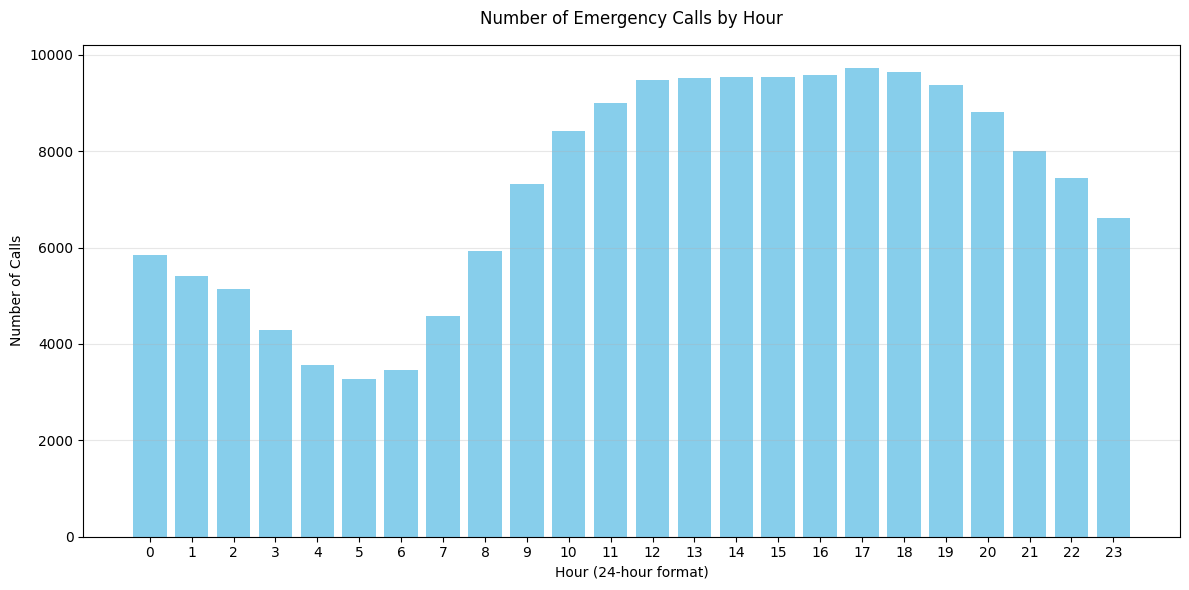


Basic Statistics:
Busiest hour: 17:00 with 9720 calls
Quietest hour: 5:00 with 3265 calls


In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# 기본 폰트를 'DejaVu Sans'로 설정 (대부분의 시스템에 기본으로 설치되어 있음)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# 데이터 준비
hour_counts = (fire_ts_df
    .select(hour('AvailableDtTS').alias('hour'))
    .groupBy('hour')
    .agg(count('*').alias('CallCount'))
    .filter('hour is not null')
    .orderBy('hour')
    .toPandas())

# 그래프 설정
plt.figure(figsize=(12, 6))

# 막대 그래프 그리기
plt.bar(hour_counts['hour'], hour_counts['CallCount'], color='skyblue')

# 그래프 꾸미기
plt.title('Number of Emergency Calls by Hour', pad=15)
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Calls')

# x축 눈금 설정
plt.xticks(range(24))

# 격자 추가
plt.grid(True, axis='y', alpha=0.3)

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 기본 통계 출력
print("\nBasic Statistics:")
print(f"Busiest hour: {hour_counts['CallCount'].idxmax()}:00 with {hour_counts['CallCount'].max()} calls")
print(f"Quietest hour: {hour_counts['CallCount'].idxmin()}:00 with {hour_counts['CallCount'].min()} calls")

> 분석

* 시간대별 신고 건수:
    - 가장 많은 신고: 오후 4-5시(17시) - 9,720건
    - 가장 적은 신고: 새벽 5시 - 3,265건
* 주요 패턴:
    - 새벽 시간(0시-5시): 신고가 적음 (3,000-5,000건)
    - 아침 시간(6시-9시): 점차 증가 (3,455 → 7,325건)
    - 낮 시간(10시-17시): 가장 많음 (8,000-9,700건)
    - 저녁 시간(18시-23시): 점차 감소 (9,637 → 7,440건)
* 특이사항:
    - null 값이 1,794건 있음 (시간 정보가 없는 신고들)
    - 오후 2시부터 6시까지(14시-18시)가 가장 바쁜 시간대
    - 새벽 5시가 가장 조용한 시간대

> 제언

- 오후 2-6시에는 더 많은 인력 필요
- 새벽 시간에는 상대적으로 적은 인력으로 운영 가능
- 아침 6시부터는 인력을 점차 증원하는 것이 좋음

In [70]:
from pyspark.sql.functions import when

(fire_ts_df
    .withColumn("dayofweek", dayofweek("IncidentDate"))
    .withColumn("day_name", 
        when(dayofweek("IncidentDate") == 1, "Sunday")
        .when(dayofweek("IncidentDate") == 2, "Monday")
        .when(dayofweek("IncidentDate") == 3, "Tuesday")
        .when(dayofweek("IncidentDate") == 4, "Wednesday")
        .when(dayofweek("IncidentDate") == 5, "Thursday")
        .when(dayofweek("IncidentDate") == 6, "Friday")
        .when(dayofweek("IncidentDate") == 7, "Saturday"))
    .groupBy("dayofweek", "day_name")
    .agg(count("*").alias("CallCount"))
    .orderBy("dayofweek")
    .show())

+---------+---------+---------+
|dayofweek| day_name|CallCount|
+---------+---------+---------+
|        1|   Sunday|    24758|
|        2|   Monday|    24720|
|        3|  Tuesday|    24467|
|        4|Wednesday|    24755|
|        5| Thursday|    24647|
|        6|   Friday|    26048|
|        7| Saturday|    25901|
+---------+---------+---------+



> 분석

- 가장 많은 신고: 금요일 (26,048건)
- 가장 적은 신고: 화요일 (24,467건)
- 주말과 주중 비교: 주말(일요일, 토요일)의 신고 수는 주중(월요일~금요일)보다 낮은 편임. 그러나 금요일은 신고 수가 많음.

In [71]:
spark.stop()